 Group 1 already loaded and split the data , but  out of testing purpose, we are doing it again

# Test Gower distance

## Steps: 

1. Loads and splits  real dataset 

2.Loads and aligns the synthetic data

3. Computes Gower similarity

4. Outputs both:

- The most similar synthetic sample for the first test sample

- The top N (3) similar synthetic samples for each test sample

In [1]:
!pip install gower==0.1.2


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gower
import numpy as np

# Step 1: Load and copy real data safely
try:
    real_data_new = pd.read_csv("real-data.csv", on_bad_lines='skip').copy()
except Exception as e:
    print("Error loading real-data.csv:", e)
    raise

# Step 2: Separate features and target
X = real_data_new.drop(columns='NObeyesdad').copy()
y = real_data_new['NObeyesdad'].copy()

# Step 3: Create test, train, val splits 
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Step 4: Load synthetic data safely
try:
    synthetic_data = pd.read_csv("synthetic-data.csv", on_bad_lines='skip').copy()
except Exception as e:
    print("Error loading synthetic-data.csv:", e)
    raise

# Step 5: Align synthetic columns
synthetic_data = synthetic_data[X_test.columns].copy()

# Step 6: Compute Gower similarity
similarity_matrix = gower.gower_matrix(X_test, synthetic_data)

# Step 7: Apply threshold and show only matches found
threshold = 0.73  # Set your desired threshold

for i in range(len(X_test)):
    similarities = similarity_matrix[i]
    matches = np.where(similarities >= threshold)[0]

    if len(matches) > 0:
        print(f"\nTest sample {i} – {len(matches)} synthetic match(es) with similarity ≥ {threshold}:")
        #print(synthetic_data.iloc[matches])
        print("Similarity scores:", similarities[matches])



Test sample 9 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.74529946]

Test sample 19 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7822733]

Test sample 93 – 8 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7468422  0.730499   0.7422455  0.73679125 0.7482039  0.7450177
 0.76884997 0.7476264 ]

Test sample 304 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.73046803]

Test sample 367 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7445419]

Test sample 387 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7536432]


In [7]:
import pandas as pd
import gower


synth = pd.read_csv('synth.csv')
original = pd.read_csv('real-data.csv')

synth = synth.drop(columns=['id'])
synth_raw = synth.copy()

In [15]:
import pandas as pd
import gower

top_n = 5
summary = []

for i, row in original.iterrows():
    gower_matrix = gower.gower_matrix(row.to_frame().T, synth)

    # Sort by similarity (lower distance = more similar)
    top_matches = gower_matrix.argsort()[0][:top_n]
    bot_matches = gower_matrix.argsort()[0][len(gower_matrix) - top_n:]

    for n, j in enumerate(top_matches):
        match = synth.iloc[j]
        no_match = synth.iloc[bot_matches[n]]
        distance = gower_matrix[0][j]
        distance_bad = gower_matrix[0][bot_matches[n]]

        print("=" * 60)
        print(f"🎯 Test Sample (ID {i}):")
        print(row.to_frame().T.to_string(index=False))
        print("\n✅ Closest Synthetic Match:")
        print(match.to_frame().T.to_string(index=False))
        print(f"\n📏 Gower Distance: {distance:.4f}")

        print("\n❌ Distant (No Match) Example:")
        print(no_match.to_frame().T.to_string(index=False))
        
        print(f"\n📏 Gower Distance Bad: {distance_bad:.4f}")
        print("=" * 60 + "\n")

        #similarities = similarity_matrix[i]
        summary.append({
            "original_id": i,
            "synth_id": j,
            "distance": distance,
            "original_row": row.to_dict(),
            "synth_row": match.to_dict()
        })

    break  # remove this break to run for all rows


🎯 Test Sample (ID 0):
Gender   Age Height Weight family_history_with_overweight FAVC FCVC  NCP      CAEC SMOKE CH2O SCC  FAF  TUE CALC                MTRANS    NObeyesdad
Female  21.0   1.62   64.0                            yes   no  2.0  3.0 Sometimes    no  2.0  no  0.0  1.0   no Public_Transportation Normal_Weight

✅ Closest Synthetic Match:
Gender   Age Height Weight family_history_with_overweight FAVC FCVC  NCP      CAEC SMOKE CH2O SCC  FAF  TUE CALC                MTRANS    NObeyesdad
Female  21.0   1.62   60.0                            yes  yes  2.0  3.0 Sometimes    no  2.0  no  0.0  1.0   no Public_Transportation Normal_Weight

📏 Gower Distance: 0.1176

❌ Distant (No Match) Example:
Gender   Age Height Weight family_history_with_overweight FAVC FCVC  NCP      CAEC SMOKE CH2O SCC  FAF  TUE      CALC  MTRANS         NObeyesdad
  Male  19.0    1.8   85.0                             no  yes  3.0  4.0 Sometimes    no  3.0  no  2.0  0.0 Sometimes Walking Overweight_Level_I

📏 Gowe

IndexError: index 4 is out of bounds for axis 0 with size 4

In [35]:

distance_thresholds = np.arange(0.01, 0.2, 0.01)
summary = []

# Test each threshold
for threshold in distance_thresholds:

    # List to keep all similar records from synth dataset
    to_remove = []

    # Find similar records for each original record
    for i,row in original.iterrows():
        
        # Calculate Gower distance
        gower_matrix = gower.gower_matrix(row.to_frame().T, synth)

        # Get all matches with distance <= threshold
        matches = gower_matrix.argsort()[0][gower_matrix[0] <= threshold]
        
        # Save matches to find how many will be removed
        for n,j in enumerate(matches):
            match = synth.iloc[j]
            to_remove.append(match)
    summary.append([threshold, len(to_remove)])



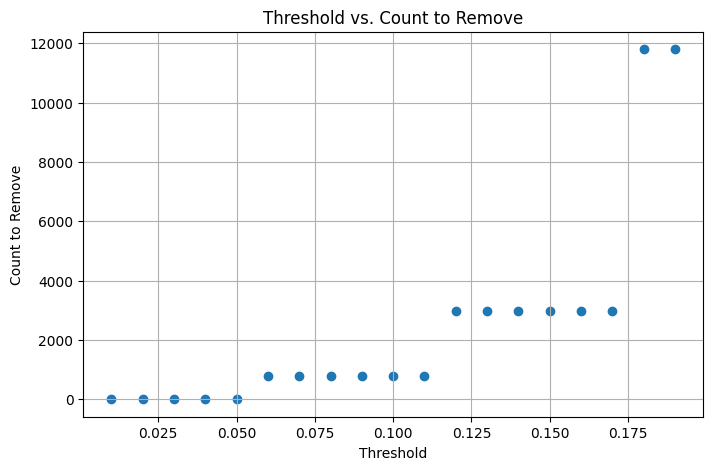

In [39]:
import matplotlib.pyplot as plt

def plot_summary_scatter(summary):
    # Unpack the list of [threshold, count] into two separate lists
    thresholds = [item[0] for item in summary]
    counts = [item[1] for item in summary]

    # Create scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(thresholds, counts)
    plt.xlabel('Threshold')
    plt.ylabel('Count to Remove')
    plt.title('Threshold vs. Count to Remove')
    plt.grid(True)
    plt.show()

plot_summary_scatter(summary)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a441f35e-4b4c-4c50-b56a-1aea6b800ed8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>